In [1]:
import glob
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.array([0,0,0], dtype='float')   
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
    def update_state(self,detected_x,detected_y,x_values,fit_coeff,img_shape):
        if len(self.recent_xfitted) == 30:
            self.recent_xfitted.pop(0)
        self.recent_xfitted.append(x_values)
        self.bestx = np.mean(self.recent_xfitted,axis=0)
        self.best_fit = (self.best_fit+fit_coeff)/2
        self.diffs = self.current_fit - fit_coeff
        self.current_fit = fit_coeff
        self.radius_of_curvature = self.compute_curvature(img_shape,detected_x,detected_y)
        self.allx = detected_x
        self.ally = detected_y
        
    def compute_curvature(self,img_shape,detected_x,detected_y):
        ym_per_pix = 30/img_shape[0]
        xm_per_pix = 3.7/img_shape[1]
        fit = np.polyfit(detected_y*ym_per_pix, detected_x*xm_per_pix, 2)
        y_eval = np.max(detected_y)
        curverad = ((1 + (2*fit[0]*y_eval*ym_per_pix + fit[1])**2)**1.5) / np.absolute(2*fit[0])
        return curverad
    
    def compute_slope(self,fit,y_value):
        return 2*y_value*fit[0]+fit[1]
    
    def get_prev_frame_status(self):
        return self.detected
    
    def set_prev_frame_status(self,flag):
        self.detected=flag
    
    def get_xvalues(self):
        return self.recent_xfitted[-1]

In [3]:
objPoints = pickle.load(open( "objPoints", "rb" ))
imgPoints = pickle.load(open("imgPoints","rb"))

In [4]:
def abs_sobel_thresh(img,orient='x',sobel_kernel=3,thresh=(0,255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0)
    else:
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled>thresh[0]) & (scaled<thresh[1])]=1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,sobel_kernel)
    mag = np.sqrt((sobelx)*(sobelx)+(sobely)*(sobely))
    scaled = np.uint(255*mag/np.max(mag))
    binary_output=np.zeros_like(scaled)
    binary_output[(scaled>mag_thresh[0]) & (scaled<mag_thresh[1])]=1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    graddir = np.arctan2(abs_sobely,abs_sobelx)
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir>thresh[0]) & (graddir<thresh[1])]=1
    return binary_output

def color_threshold(img,ch_ind,thresh=(0,255)):
    channel = img[:,:,ch_ind]
    binary = np.zeros_like(channel)
    binary[(channel>=thresh[0]) & (channel<=thresh[1])] =1
    return binary

In [30]:
def image_thresholding(undist):
    ksize = 5
    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(5, 100))
    grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(undist, sobel_kernel=9, mag_thresh=(20, 100))
    dir_binary = dir_threshold(undist, sobel_kernel=21, thresh=(-1.3,1.3))
    hls = cv2.cvtColor(undist,cv2.COLOR_RGB2HLS)
    H_th = color_threshold(hls,0,(5,50))
    S_th = color_threshold(hls,2,(100,255))
    rgb_th = color_threshold(undist,0,(200,255))
    combined = np.zeros_like(dir_binary)
    combined[ ((gradx == 1)  & (grady==1)) |( (mag_binary == 1) &(dir_binary==1)) | ((H_th==1)&(S_th==1) )] = 1
    return combined

In [31]:
def perspective_transform(thrs_image):
    sh = thrs_image.shape
    
    tl = [sh[1]*0.4,sh[0]*0.65]
    tr = [sh[1]*0.6,sh[0]*0.65]
    bl = [sh[1]*0.1,sh[0]]
    br = [sh[1],sh[0]]

    src = np.float32([tl,tr,br,bl])
    dst = np.float32([[200,0],[1000,100],[1000,680],[200,680]])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    img_size = (sh[1],sh[0])
    warped = cv2.warpPerspective(thrs_image,M,img_size,flags=cv2.INTER_LINEAR)
    return warped, M, Minv

In [32]:
def sliding_window(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 20

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return leftx,lefty,rightx,righty,ploty,left_fit,right_fit,left_fitx,right_fitx


In [33]:
def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return leftx,lefty,rightx,righty,ploty,left_fit,right_fit,left_fitx,right_fitx
   

In [34]:
def detect_lanes(image):
    ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objPoints,imgPoints,image.shape[1::-1],None,None)
    undist = cv2.undistort(image,mtx,dist,None,mtx)
    thresholded = image_thresholding(undist)
    warped,M,Minv = perspective_transform(thresholded)
    
    if left_lane.get_prev_frame_status():
        leftx, lefty, rightx, righty, ploty, left_fit, right_fit, left_fitx, right_fitx = search_around_poly(warped,left_lane.best_fit,right_lane.best_fit)
        diff_curvature  = abs(left_lane.compute_curvature(warped.shape,leftx,lefty) - right_lane.compute_curvature(warped.shape,rightx,righty))
        diff_slope = abs(left_lane.compute_slope(left_fit,np.mean(lefty)) - right_lane.compute_slope(right_fit,np.mean(righty)))
        if (diff_curvature < 2) & (diff_slope < 1):
            left_lane.update_state(leftx,lefty,left_fitx,left_fit,warped.shape)
            right_lane.update_state(rightx,righty,right_fitx,right_fit,warped.shape)
        else:
            left_lane.set_prev_frame_status(False)
            right_lane.set_prev_frame_status(False)
    else:
        leftx, lefty, rightx, righty, ploty, left_fit, right_fit, left_fitx, right_fitx = sliding_window(warped)
        left_lane.update_state(leftx,lefty,left_fitx,left_fit,warped.shape)
        right_lane.update_state(rightx,righty,right_fitx,right_fit,warped.shape)
        left_lane.set_prev_frame_status(True)
        right_lane.set_prev_frame_status(True)
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_lane.get_xvalues(), ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.get_xvalues(), ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    color_thresh  = np.dstack((thresholded*255,thresholded*255,thresholded*255)).astype(np.uint8)
    result = cv2.addWeighted(color_thresh, 1, newwarp, 0.3, 0)
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (100,100)
    fontScale              = 1
    fontColor              = (255,0,0)
    lineType               = 2
    txt = "Left and right radius of curvature " + str(left_lane.radius_of_curvature/1000) + " , " + str(right_lane.radius_of_curvature/1000)
    cv2.putText(result,txt, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    return result
    

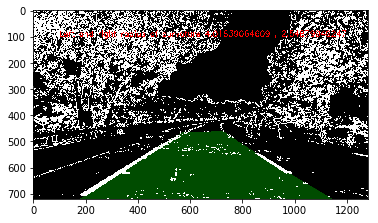

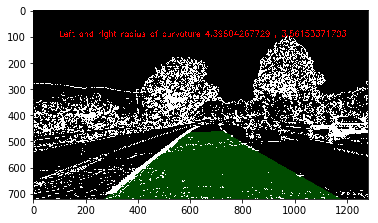

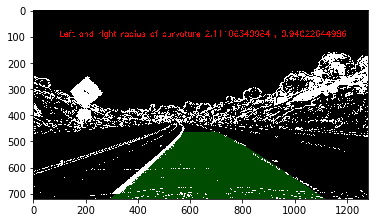

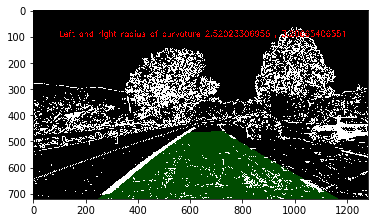

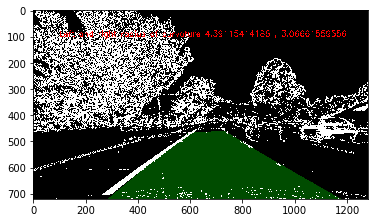

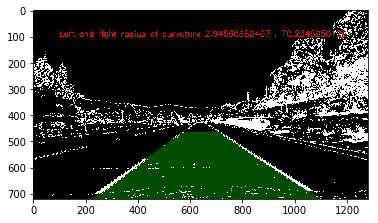

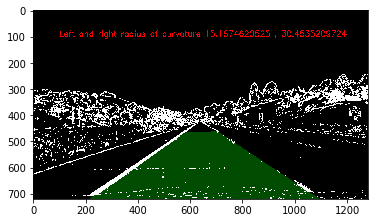

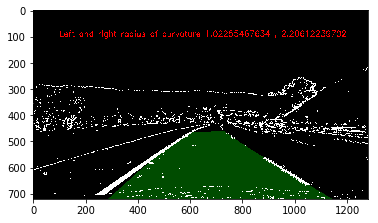

In [35]:
for img_name in glob.glob("test_images/*.jpg"):
    left_lane = Line()
    right_lane = Line()
    image = mpimg.imread(img_name)
    result = detect_lanes(image)
    plt.figure()
    plt.imshow(result)

In [36]:
def process_image(image):
    return detect_lanes(image)

In [37]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [38]:
white_output = 'test_videos_output/project_video.mp4'
left_lane = Line()
right_lane = Line()
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|██████████| 485/485 [06:47<00:00,  1.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 5min 57s, sys: 6.91 s, total: 6min 4s
Wall time: 6min 50s
